APPROACH 2: Stylometric Analysis + Claim Verification Pipeline

In [ ]:
# SECTION 1: SETUP AND INSTALLATIONS
# ============================================================================
!pip install transformers datasets torch scikit-learn
!pip install textstat vaderSentiment spacy nltk
!pip install matplotlib seaborn plotly wordcloud
!python -m spacy download en_core_web_sm

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import re
import string
from collections import Counter

# NLP libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk import word_tokenize, sent_tokenize, pos_tag, ne_chunk
from nltk.corpus import stopwords
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat

# Deep learning
# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm


print("✅ All libraries imported successfully!")

# Load spacy model
nlp = spacy.load('en_core_web_sm')

# ============================================================================


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 132.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


✅ All libraries imported successfully!


In [ ]:
# SECTION 2: LOAD DATA
# ============================================================================
def load_data():
    """Load your dataset - modify based on your data location"""
    df_fake = pd.read_csv('/content/Fake.csv')
    df_fake['label'] = 1

    df_real = pd.read_csv('/content/True.csv')
    df_real['label'] = 0

    df = pd.concat([df_fake, df_real], axis=0).reset_index(drop=True)

    return df

df = load_data()
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['label'].value_counts()}")

# Sample for faster processing (remove .head() for full dataset)
df = df.head(5000)

# ============================================================================


Dataset shape: (44898, 5)
Class distribution:
label
1    23481
0    21417
Name: count, dtype: int64


In [ ]:
#SECTION 3: STAGE 1 - WRITING STYLE ANALYSIS
# ============================================================================
import nltk

# Download all necessary tokenizers and taggers
nltk.download('punkt')
nltk.download('punkt_tab')  # NEW: required by latest NLTK
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("\n" + "="*50)
print("STAGE 1: WRITING STYLE ANALYSIS")
print("="*50)

class StyleAnalyzer:
    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()
        self.stop_words = set(stopwords.words('english'))

        # Emotional manipulation keywords
        self.emotional_words = {
            'fear': ['terror', 'horrific', 'dangerous', 'threat', 'scary', 'frightening',
                    'alarming', 'crisis', 'disaster', 'catastrophe', 'doom'],
            'anger': ['outrage', 'furious', 'enraged', 'shocking', 'appalling', 'disgusting',
                     'horrible', 'terrible', 'awful', 'evil', 'hate'],
            'excitement': ['amazing', 'incredible', 'unbelievable', 'shocking', 'stunning',
                          'breaking', 'exclusive', 'bombshell', 'explosive'],
            'urgency': ['now', 'immediately', 'urgent', 'breaking', 'alert', 'must', 'need']
        }

    # ========================================================================
    # SUB-DIVISION 1: Emotional Manipulation Features
    # ========================================================================
    def analyze_emotional_manipulation(self, text):
        """Detect emotional manipulation patterns"""
        text_lower = text.lower()
        features = {}

        # 1. Sentiment extremity
        sentiment = self.vader.polarity_scores(text)
        features['sentiment_compound'] = sentiment['compound']
        features['sentiment_extremity'] = abs(sentiment['compound'])
        features['sentiment_positive'] = sentiment['pos']
        features['sentiment_negative'] = sentiment['neg']

        # 2. Emotional word count by category
        words = word_tokenize(text_lower)
        for emotion, keywords in self.emotional_words.items():
            count = sum(1 for word in words if word in keywords)
            features[f'emotion_{emotion}_count'] = count
            features[f'emotion_{emotion}_ratio'] = count / len(words) if words else 0

        # 3. Exclamation and question marks (indicates sensationalism)
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('?')
        features['caps_ratio'] = sum(1 for c in text if c.isupper()) / len(text) if text else 0

        # 4. Superlatives and absolutes
        superlatives = ['most', 'best', 'worst', 'always', 'never', 'all', 'none', 'every']
        features['superlative_count'] = sum(1 for word in words if word in superlatives)

        return features

    # ========================================================================
    # SUB-DIVISION 2: Linguistic Complexity Features
    # ========================================================================
    def analyze_linguistic_complexity(self, text):
        """Analyze text complexity and readability"""
        features = {}

        # 1. Readability scores
        features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
        features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
        features['gunning_fog'] = textstat.gunning_fog(text)
        features['automated_readability'] = textstat.automated_readability_index(text)

        # 2. Sentence structure
        sentences = sent_tokenize(text)
        features['sentence_count'] = len(sentences)
        features['avg_sentence_length'] = np.mean([len(word_tokenize(s)) for s in sentences]) if sentences else 0
        features['sentence_length_std'] = np.std([len(word_tokenize(s)) for s in sentences]) if sentences else 0

        # 3. Word complexity
        words = word_tokenize(text.lower())
        features['word_count'] = len(words)
        features['avg_word_length'] = np.mean([len(w) for w in words]) if words else 0
        features['lexical_diversity'] = len(set(words)) / len(words) if words else 0

        # 4. Syllable complexity
        features['syllable_count'] = textstat.syllable_count(text)
        features['avg_syllables_per_word'] = features['syllable_count'] / features['word_count'] if features['word_count'] > 0 else 0

        return features

    # ========================================================================
    # SUB-DIVISION 3: Part-of-Speech Analysis
    # ========================================================================
    def analyze_pos_patterns(self, text):
        """Analyze part-of-speech patterns"""
        features = {}

        words = word_tokenize(text)
        pos_tags = pos_tag(words)

        # Count POS tags
        pos_counts = Counter([tag for word, tag in pos_tags])
        total = len(pos_tags)

        # Key POS ratios
        features['noun_ratio'] = (pos_counts['NN'] + pos_counts['NNS'] + pos_counts['NNP'] + pos_counts['NNPS']) / total if total > 0 else 0
        features['verb_ratio'] = (pos_counts['VB'] + pos_counts['VBD'] + pos_counts['VBG'] + pos_counts['VBN'] + pos_counts['VBP'] + pos_counts['VBZ']) / total if total > 0 else 0
        features['adjective_ratio'] = (pos_counts['JJ'] + pos_counts['JJR'] + pos_counts['JJS']) / total if total > 0 else 0
        features['adverb_ratio'] = (pos_counts['RB'] + pos_counts['RBR'] + pos_counts['RBS']) / total if total > 0 else 0
        features['pronoun_ratio'] = (pos_counts['PRP'] + pos_counts['PRP$']) / total if total > 0 else 0

        return features

    # ========================================================================
    # SUB-DIVISION 4: Named Entity Analysis
    # ========================================================================
    def analyze_named_entities(self, text):
        """Analyze named entities using spaCy"""
        features = {}

        doc = nlp(text[:1000000])  # spaCy has character limit

        # Entity counts by type
        entity_counts = Counter([ent.label_ for ent in doc.ents])

        features['person_count'] = entity_counts['PERSON']
        features['org_count'] = entity_counts['ORG']
        features['gpe_count'] = entity_counts['GPE']  # Geopolitical entities
        features['date_count'] = entity_counts['DATE']
        features['total_entities'] = len(doc.ents)
        features['entity_density'] = len(doc.ents) / len(doc) if len(doc) > 0 else 0

        return features

    # ========================================================================
    # SUB-DIVISION 5: Source and Citation Analysis
    # ========================================================================
    def analyze_sources(self, text):
        """Analyze source citations and credibility markers"""
        features = {}

        text_lower = text.lower()

        # 1. Citation markers
        citation_markers = ['according to', 'reported by', 'sources say', 'study shows',
                           'research indicates', 'experts say', 'official', 'confirmed']
        features['citation_count'] = sum(1 for marker in citation_markers if marker in text_lower)

        # 2. Vague source indicators (red flags)
        vague_sources = ['some say', 'many believe', 'people think', 'rumor has it',
                        'allegedly', 'reportedly', 'supposedly', 'claims']
        features['vague_source_count'] = sum(1 for source in vague_sources if source in text_lower)

        # 3. URL/link presence
        features['url_count'] = len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))

        # 4. Quotation usage
        features['quote_count'] = text.count('"') // 2  # Pairs of quotes

        return features

    # ========================================================================
    # MAIN EXTRACTION METHOD
    # ========================================================================
    def extract_all_features(self, text):
        """Extract all stylometric features"""
        all_features = {}

        # Combine all feature sets
        all_features.update(self.analyze_emotional_manipulation(text))
        all_features.update(self.analyze_linguistic_complexity(text))
        all_features.update(self.analyze_pos_patterns(text))
        all_features.update(self.analyze_named_entities(text))
        all_features.update(self.analyze_sources(text))

        return all_features

# Initialize analyzer and extract features
print("\n📊 Extracting stylometric features...")
analyzer = StyleAnalyzer()

# Extract features for all texts
feature_list = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['text']) if 'text' in df.columns else str(row['title']) + " " + str(row.get('text', ''))
    features = analyzer.extract_all_features(text)
    features['label'] = row['label']
    feature_list.append(features)

# Convert to DataFrame
df_features = pd.DataFrame(feature_list)
print(f"✅ Extracted {len(df_features.columns)-1} stylometric features")
print(df_features.head())

# ============================================================================


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



STAGE 1: WRITING STYLE ANALYSIS

📊 Extracting stylometric features...


100%|██████████| 5000/5000 [09:24<00:00,  8.86it/s]


✅ Extracted 43 stylometric features
   sentiment_compound  sentiment_extremity  sentiment_positive  \
0             -0.8681               0.8681               0.143   
1             -0.7141               0.7141               0.073   
2             -0.9953               0.9953               0.059   
3             -0.9176               0.9176               0.043   
4              0.3134               0.3134               0.075   

   sentiment_negative  emotion_fear_count  emotion_fear_ratio  \
0               0.134                   0                 0.0   
1               0.085                   0                 0.0   
2               0.140                   0                 0.0   
3               0.074                   0                 0.0   
4               0.077                   0                 0.0   

   emotion_anger_count  emotion_anger_ratio  emotion_excitement_count  \
0                    2             0.003339                         1   
1                    0        


VISUALIZING STYLOMETRIC FEATURES


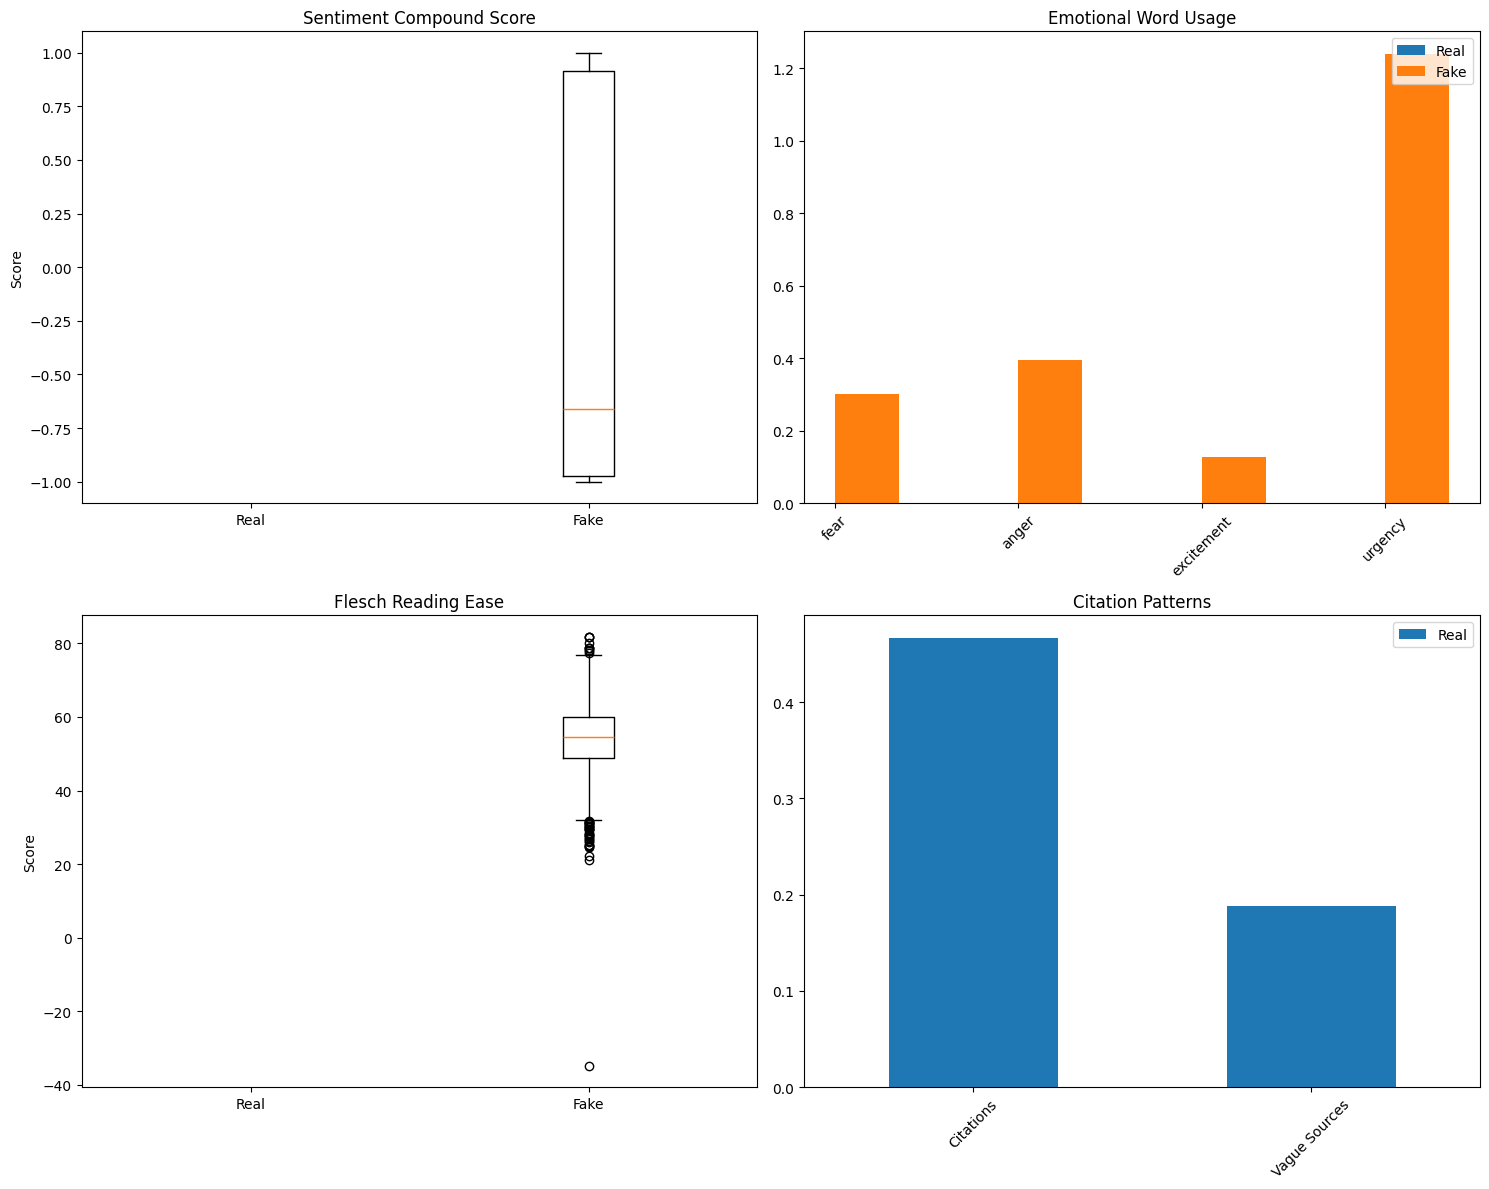

In [ ]:
# SECTION 4: VISUALIZE STYLOMETRIC FEATURES
# ============================================================================
print("\n" + "="*50)
print("VISUALIZING STYLOMETRIC FEATURES")
print("="*50)

# 1. Feature importance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sentiment comparison
axes[0, 0].boxplot([df_features[df_features['label']==0]['sentiment_compound'],
                     df_features[df_features['label']==1]['sentiment_compound']])
axes[0, 0].set_xticklabels(['Real', 'Fake'])
axes[0, 0].set_title('Sentiment Compound Score')
axes[0, 0].set_ylabel('Score')

# Emotional manipulation
emotion_cols = [col for col in df_features.columns if 'emotion_' in col and '_count' in col]
emotion_means_real = df_features[df_features['label']==0][emotion_cols].mean()
emotion_means_fake = df_features[df_features['label']==1][emotion_cols].mean()

x = np.arange(len(emotion_cols))
width = 0.35
axes[0, 1].bar(x - width/2, emotion_means_real, width, label='Real')
axes[0, 1].bar(x + width/2, emotion_means_fake, width, label='Fake')
axes[0, 1].set_title('Emotional Word Usage')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([col.replace('emotion_', '').replace('_count', '') for col in emotion_cols], rotation=45)
axes[0, 1].legend()

# Readability scores
axes[1, 0].boxplot([df_features[df_features['label']==0]['flesch_reading_ease'],
                     df_features[df_features['label']==1]['flesch_reading_ease']])
axes[1, 0].set_xticklabels(['Real', 'Fake'])
axes[1, 0].set_title('Flesch Reading Ease')
axes[1, 0].set_ylabel('Score')

# Citation patterns
citation_data = df_features[['citation_count', 'vague_source_count', 'label']].groupby('label').mean()
citation_data.T.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Citation Patterns')
axes[1, 1].set_xticklabels(['Citations', 'Vague Sources'], rotation=45)
axes[1, 1].legend(['Real', 'Fake'])

plt.tight_layout()
plt.savefig('stylometric_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================


In [ ]:
# ==================================================
# STAGE 0: DATA LOADING & PREPARATION
# ==================================================

import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# ==============================
# 1️⃣ Load both datasets
# ==============================
df_fake = pd.read_csv("/content/Fake.csv")
df_real = pd.read_csv("/content/True.csv")

# Assign labels
df_fake["label"] = 1   # Fake = 1
df_real["label"] = 0   # Real = 0

# Combine and shuffle
df = pd.concat([df_fake, df_real]).sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Data loaded successfully!")
print(df["label"].value_counts())

# ==================================================
# STAGE 1: WRITING STYLE ANALYSIS (STYLOMETRIC)
# ==================================================

import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# Define Stylometric Feature Extractor
class StylometricAnalyzer:
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))

    def avg_sentence_length(self, text):
        sentences = sent_tokenize(text)
        words = word_tokenize(text)
        return len(words) / len(sentences) if len(sentences) > 0 else 0

    def avg_word_length(self, text):
        words = word_tokenize(text)
        return np.mean([len(w) for w in words]) if len(words) > 0 else 0

    def stopword_ratio(self, text):
        words = word_tokenize(text)
        stop_count = len([w for w in words if w.lower() in self.stop_words])
        return stop_count / len(words) if len(words) > 0 else 0

    def punctuation_ratio(self, text):
        punct = len(re.findall(r"[^\w\s]", text))
        return punct / len(text) if len(text) > 0 else 0

    def lexical_richness(self, text):
        words = word_tokenize(text)
        return len(set(words)) / len(words) if len(words) > 0 else 0

    def extract_all_features(self, text):
        return {
            "avg_sentence_length": self.avg_sentence_length(text),
            "avg_word_length": self.avg_word_length(text),
            "stopword_ratio": self.stopword_ratio(text),
            "punctuation_ratio": self.punctuation_ratio(text),
            "lexical_richness": self.lexical_richness(text),
        }

# Initialize analyzer
analyzer = StylometricAnalyzer()

# ==================================================
# STAGE 2: FEATURE EXTRACTION
# ==================================================

feature_list = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    # Combine title + text if both exist
    text = str(row.get("title", "")) + " " + str(row.get("text", ""))
    features = analyzer.extract_all_features(text)
    features["label"] = row["label"]
    feature_list.append(features)

df_features = pd.DataFrame(feature_list)

print("\n✅ Feature extraction complete!")
print(df_features.head())
print("\nLabel distribution:\n", df_features["label"].value_counts())

# ==================================================
# STAGE 3: TRAINING STYLOMETRIC CLASSIFIER
# ==================================================

X = df_features.drop("label", axis=1)
y = df_features["label"]

# Safety check: both labels must exist
if len(y.unique()) < 2:
    raise ValueError("❌ Only one unique label found. Make sure both 0 (real) and 1 (fake) samples exist!")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("\n==================================================")
print("MODEL PERFORMANCE")
print("==================================================")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


✅ Data loaded successfully!
label
1    23481
0    21417
Name: count, dtype: int64


100%|██████████| 44898/44898 [06:16<00:00, 119.20it/s]



✅ Feature extraction complete!
   avg_sentence_length  avg_word_length  stopword_ratio  punctuation_ratio  \
0            40.000000         4.645000        0.380000           0.015206   
1            33.666667         4.504950        0.352035           0.028507   
2            25.642857         4.406685        0.370474           0.029273   
3            24.444444         5.095455        0.359091           0.025487   
4            29.238095         4.320847        0.372964           0.026308   

   lexical_richness  label  
0          0.670000      1  
1          0.430143      0  
2          0.515320      0  
3          0.590909      1  
4          0.524430      0  

Label distribution:
 label
1    23481
0    21417
Name: count, dtype: int64

MODEL PERFORMANCE
Accuracy: 0.8874164810690424

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4270
           1       0.88      0.90      0.89      4710

    accuracy


TRAINING STYLOMETRIC CLASSIFIER

🤖 Training Random Forest...
🤖 Training Gradient Boosting...
🤖 Training Logistic Regression...

Random Forest Results:
  Accuracy:  0.8695
  Precision: 0.8844
  Recall:    0.8633
  F1-Score:  0.8737

Gradient Boosting Results:
  Accuracy:  0.8341
  Precision: 0.8700
  Recall:    0.8026
  F1-Score:  0.8350

Logistic Regression Results:
  Accuracy:  0.7674
  Precision: 0.7867
  Recall:    0.7617
  F1-Score:  0.7740


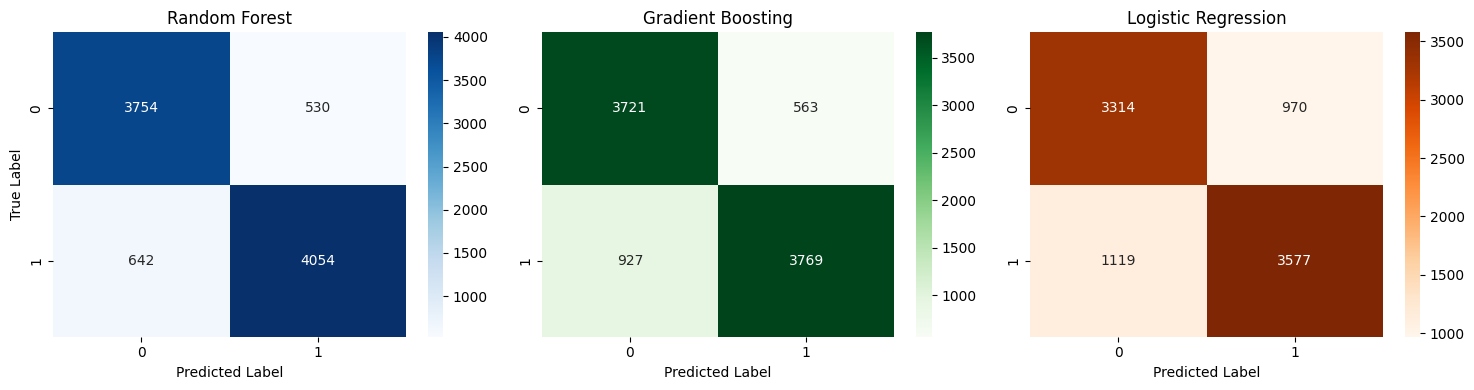

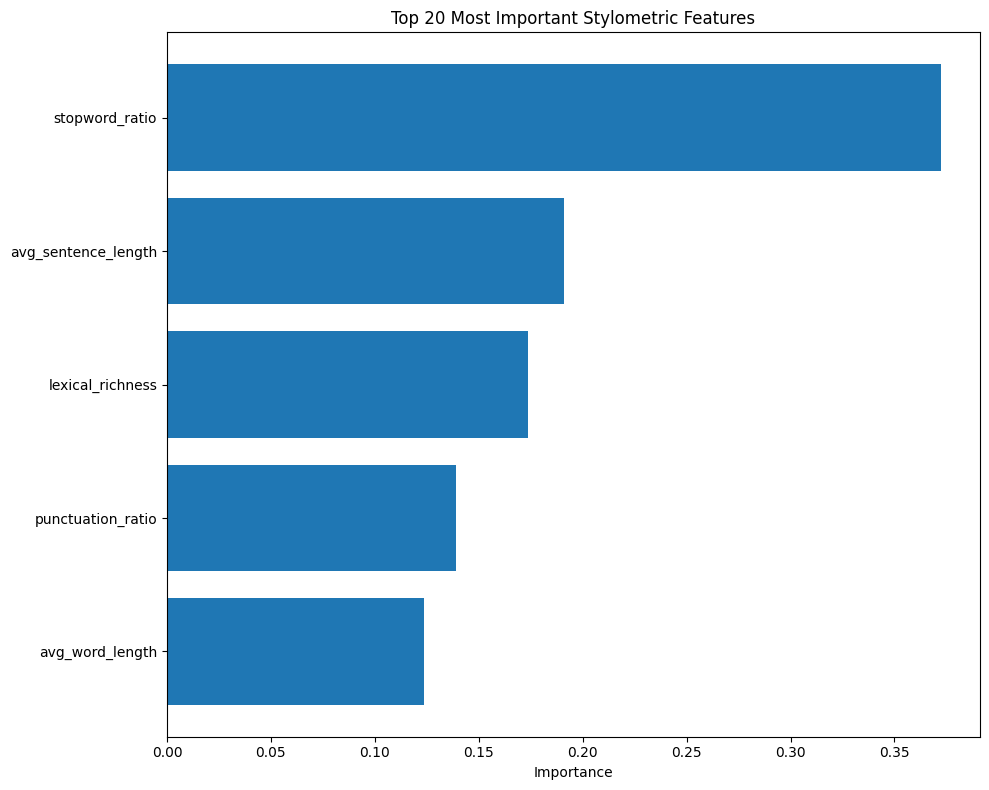


💾 Saving Stage 1 models...

✅ Stage 1 training complete!

STAGE 2: CLAIM VERIFICATION (TRANSFORMER)
Using device: cuda

🤖 Loading DistilBERT model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Training DistilBERT classifier...

Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 2245/2245 [28:08<00:00,  1.33it/s]


Train Loss: 0.0132 | Train Accuracy: 0.9965


Evaluating: 100%|██████████| 562/562 [03:18<00:00,  2.83it/s]


Val Accuracy: 0.9991

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 2245/2245 [28:11<00:00,  1.33it/s]


Train Loss: 0.0021 | Train Accuracy: 0.9995


Evaluating: 100%|██████████| 562/562 [03:16<00:00,  2.86it/s]


Val Accuracy: 0.9998

Epoch 3/3
--------------------------------------------------


Training:   3%|▎         | 66/2245 [00:49<27:21,  1.33it/s]

In [ ]:
# ============================================================================
# SECTION 5: STAGE 1 MODEL TRAINING (Stylometric Classifier)
# ============================================================================
print("\n" + "="*50)
print("TRAINING STYLOMETRIC CLASSIFIER")
print("="*50)

# Prepare data
X = df_features.drop('label', axis=1)
y = df_features['label']

# Handle any NaN or inf values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
print("\n🤖 Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Train Gradient Boosting
print("🤖 Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

# Train Logistic Regression
print("🤖 Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary'
    )

    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return y_pred, accuracy, precision, recall, f1

rf_pred, rf_acc, rf_prec, rf_rec, rf_f1 = evaluate_model(
    rf_model, X_test_scaled, y_test, "Random Forest"
)
gb_pred, gb_acc, gb_prec, gb_rec, gb_f1 = evaluate_model(
    gb_model, X_test_scaled, y_test, "Gradient Boosting"
)
lr_pred, lr_acc, lr_prec, lr_rec, lr_f1 = evaluate_model(
    lr_model, X_test_scaled, y_test, "Logistic Regression"
)

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm_rf = confusion_matrix(y_test, rf_pred)
cm_gb = confusion_matrix(y_test, gb_pred)
cm_lr = confusion_matrix(y_test, lr_pred)

sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Random Forest')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_gb, annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('Gradient Boosting')
axes[1].set_xlabel('Predicted Label')

sns.heatmap(cm_lr, annot=True, fmt='d', ax=axes[2], cmap='Oranges')
axes[2].set_title('Logistic Regression')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('stylometric_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance (Random Forest)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Stylometric Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save Stage 1 models
print("\n💾 Saving Stage 1 models...")
pickle.dump(rf_model, open('stylometric_rf_model.pkl', 'wb'))
pickle.dump(scaler, open('stylometric_scaler.pkl', 'wb'))

print("\n✅ Stage 1 training complete!")

# ============================================================================
# SECTION 6: STAGE 2 - CLAIM VERIFICATION WITH TRANSFORMER
# ============================================================================
print("\n" + "="*50)
print("STAGE 2: CLAIM VERIFICATION (TRANSFORMER)")
print("="*50)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare text data
df['text_full'] = df.apply(
    lambda x: str(x.get('title', '')) + " " + str(x.get('text', '')),
    axis=1
)

# Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split data for transformer (using same random state as Stage 1)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text_full'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label'].values
)

# Initialize tokenizer and model
print("\n🤖 Loading DistilBERT model...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)
model.to(device)

# Create datasets and dataloaders
train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return correct_predictions.double() / len(data_loader.dataset), all_preds, all_labels

# Train the transformer model
print("\n🚀 Training DistilBERT classifier...")
history = {'train_acc': [], 'train_loss': [], 'val_acc': []}

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('-' * 50)

    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    val_acc, _, _ = eval_model(model, test_loader, device)
    print(f'Val Accuracy: {val_acc:.4f}')

    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())

# Final evaluation
print("\n📊 Final Evaluation on Test Set:")
test_acc, test_preds, test_true = eval_model(model, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Detailed metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    test_true, test_preds, average='binary'
)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('DistilBERT Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('transformer_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save transformer model
print("\n💾 Saving DistilBERT model...")
model.save_pretrained('./distilbert_fake_news_model')
tokenizer.save_pretrained('./distilbert_fake_news_tokenizer')

print("\n✅ Stage 2 training complete!")

In [ ]:
# ============================================================================
# SECTION 7: HYBRID ENSEMBLE (STAGE 1 + STAGE 2) - FIXED VERSION
# ============================================================================
print("\n" + "="*50)
print("HYBRID ENSEMBLE: COMBINING BOTH STAGES")
print("="*50)

# IMPORTANT: We need to create a common test set that both models can use
# We'll use the indices from df_features (which matches with X_test)

print("\n🔮 Generating predictions from both stages...")

# Stage 1 predictions (stylometric) - already have these
stylometric_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Stage 2 predictions (transformer) - need to get predictions for the SAME samples
# Get the actual indices from X_test (these are indices in df_features, which match df)
test_indices = X_test.index.tolist()

# Get corresponding texts and labels from original df
# Since df_features and df have the same order (we built df_features from df)
test_texts_for_ensemble = df.iloc[test_indices]['text_full'].values
test_labels_for_ensemble = df.iloc[test_indices]['label'].values

print(f"Test set size: {len(test_indices)} samples")
print(f"Stylometric predictions: {len(stylometric_probs)}")
print(f"Texts for transformer: {len(test_texts_for_ensemble)}")

# Create dataset for transformer predictions
ensemble_dataset = NewsDataset(test_texts_for_ensemble, test_labels_for_ensemble, tokenizer)
ensemble_loader = DataLoader(ensemble_dataset, batch_size=16, shuffle=False)

# Get transformer predictions
model.eval()
transformer_probs = []

with torch.no_grad():
    for batch in tqdm(ensemble_loader, desc="Getting transformer predictions"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        transformer_probs.extend(probs[:, 1].cpu().numpy())

transformer_probs = np.array(transformer_probs)

print(f"Transformer predictions: {len(transformer_probs)}")

# Verify all arrays have the same length
assert len(stylometric_probs) == len(transformer_probs) == len(test_labels_for_ensemble), \
    "Prediction arrays have different lengths!"

# Ensemble strategies
print("\n🎯 Testing different ensemble strategies...")

# 1. Simple averaging
ensemble_avg = (stylometric_probs + transformer_probs) / 2
ensemble_avg_pred = (ensemble_avg > 0.5).astype(int)

# 2. Weighted averaging (favor transformer slightly)
ensemble_weighted = (0.4 * stylometric_probs + 0.6 * transformer_probs)
ensemble_weighted_pred = (ensemble_weighted > 0.5).astype(int)

# 3. Voting (hard predictions)
stylometric_pred = (stylometric_probs > 0.5).astype(int)
transformer_pred = (transformer_probs > 0.5).astype(int)
ensemble_vote = ((stylometric_pred + transformer_pred) >= 1).astype(int)

# Evaluation function
def evaluate_ensemble(predictions, true_labels, method_name):
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

    print(f"\n{method_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return accuracy, precision, recall, f1

print("\n" + "="*50)
print("ENSEMBLE RESULTS")
print("="*50)

# Individual models
print("\nStage 1 (Stylometric Only):")
stylometric_only_pred = (stylometric_probs > 0.5).astype(int)
styl_acc, styl_prec, styl_rec, styl_f1 = evaluate_ensemble(stylometric_only_pred, test_labels_for_ensemble, "Stylometric RF")

print("\nStage 2 (Transformer Only):")
transformer_only_pred = (transformer_probs > 0.5).astype(int)
trans_acc, trans_prec, trans_rec, trans_f1 = evaluate_ensemble(transformer_only_pred, test_labels_for_ensemble, "DistilBERT")

# Ensemble methods
avg_acc, avg_prec, avg_rec, avg_f1 = evaluate_ensemble(ensemble_avg_pred, test_labels_for_ensemble, "Ensemble (Average)")
weighted_acc, weighted_prec, weighted_rec, weighted_f1 = evaluate_ensemble(ensemble_weighted_pred, test_labels_for_ensemble, "Ensemble (Weighted)")
vote_acc, vote_prec, vote_rec, vote_f1 = evaluate_ensemble(ensemble_vote, test_labels_for_ensemble, "Ensemble (Voting)")

# Comparison visualization
comparison_df = pd.DataFrame({
    'Model': ['Stylometric', 'Transformer', 'Avg Ensemble', 'Weighted Ensemble', 'Vote Ensemble'],
    'Accuracy': [styl_acc, trans_acc, avg_acc, weighted_acc, vote_acc],
    'F1-Score': [styl_f1, trans_f1, avg_f1, weighted_f1, vote_f1]
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# F1-Score comparison
axes[1].bar(comparison_df['Model'], comparison_df['F1-Score'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('F1-Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix for best ensemble method
best_ensemble = ensemble_weighted_pred  # Usually weighted performs best
cm_ensemble = confusion_matrix(test_labels_for_ensemble, best_ensemble)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Weighted Ensemble Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('ensemble_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Ensemble analysis complete!")
print(f"\n🏆 Best performing model: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']}")
print(f"   with accuracy: {comparison_df['Accuracy'].max():.4f}")


HYBRID ENSEMBLE: COMBINING BOTH STAGES

🔮 Generating predictions from both stages...


NameError: name 'rf_model' is not defined